In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(purrr)
quiet_library(Seurat)
quiet_library(H5weaver)
quiet_library(dplyr)
quiet_library(matrixStats)

In [2]:
default_model <- "GeneModel-GB-Exponential-Extend-15"

In [3]:
h5_files <- list.files("../data/", pattern = ".h5", full.names = TRUE)

In [4]:
rna_mat <- do.call(cbind, map(h5_files, read_h5_dgCMatrix))
rna_so <- CreateSeuratObject(rna_mat)
rna_so <- NormalizeData(rna_so)

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”


In [5]:
rna_so <- FindVariableFeatures(rna_so, nfeatures = 4000)

In [6]:
var_genes <- VariableFeatures(rna_so)
str(var_genes)

 chr [1:4000] "IGKC" "JCHAIN" "IGHA1" "ZNF385D" "SOX5" "IGHG1" "NKAIN2" ...


In [7]:
res_files <- list.files("model_cors/", full.names = TRUE)

In [8]:
res_list <- map(res_files, read.csv)

In [9]:
res_df <- map_dfc(res_list, "cor")

New names:
* NA -> ...1
* NA -> ...2
* NA -> ...3
* NA -> ...4
* NA -> ...5
* ...



In [10]:
names(res_df) <- sub("_cor.csv","",basename(res_files))

In [11]:
res_mat <- as.matrix(res_df)
rownames(res_mat) <- res_list[[1]]$GeneExpressionMatrix_name

In [12]:
res_mat[is.na(res_mat)] <- 0

### For each gene, which model works best/worst

In [13]:
cor_df <- data.frame(gene = rownames(res_mat),
                     default_cor = res_mat[,default_model],
                     max_cor = rowMaxs(res_mat),
                     min_cor = rowMins(res_mat),
                     mean_cor = rowMeans(res_mat),
                     median_cor = rowMedians(res_mat),
                     diff_cor = rowMaxs(res_mat) - rowMins(res_mat),
                     diff_default = rowMaxs(res_mat) - res_mat[,default_model],
                     max_model = apply(res_mat, 1, function(x) { colnames(res_mat)[which.max(x)] }),
                     min_model = apply(res_mat, 1, function(x) { colnames(res_mat)[which.min(x)] }),
                     seurat_var_gene = rownames(res_mat) %in% var_genes)

Genes for which model selection matters the most:

In [14]:
cor_df %>%
  arrange(desc(diff_cor)) %>%
  head(10)

,gene,default_cor,max_cor,min_cor,mean_cor,median_cor,diff_cor,diff_default,max_model,min_model,seurat_var_gene
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>
1,SATB1-AS1,0.8495790,0.8690188,-0.5803292,0.3609375,0.7225107,1.449348,0.019439866,GeneModel-GB-NoBoundary-Exponential-3,GeneModel-TSS-NoBoundary-Exponential-4,TRUE
2,ETS1,0.5646126,0.8155334,-0.5246559,0.2526499,0.3302535,1.340189,0.250920841,GeneModel-GB-NoBoundary-Exponential-1,Promoter_25K,FALSE
3,PACS1,0.5619790,0.7900915,-0.5012200,0.2344935,0.2645356,1.291312,0.228112496,GeneModel-GB-NoBoundary-Exponential-3,Promoter_5K,FALSE
4,ITPKB-AS1,0.1201049,0.8172430,-0.4492389,0.2899589,0.2877402,1.266482,0.697138090,GeneModel-TSS-Constant-3,GeneBody_2000_0,FALSE
5,ZNF860,0.8704126,0.9016832,-0.3046849,0.6350575,0.7912454,1.206368,0.031270558,GeneModel-GB-NoBoundary-Exponential-4,Promoter_100K,FALSE
6,FCGRT,-0.2928284,0.7469611,-0.4568201,0.1216701,0.1258678,1.203781,1.039789445,GeneBody_0_0,GeneModel-GB-NoBoundary-Exponential-4,FALSE
7,OXNAD1,0.7863728,0.8058080,-0.3897989,0.5492462,0.7795097,1.195607,0.019435236,GeneModel-TSS-Constant-4,Promoter_25K,FALSE
8,TGFBR2,0.8353716,0.8451250,-0.3444687,0.6092090,0.8353716,1.189594,0.009753384,GeneModel-GB-Exponential-4,Promoter_1K,TRUE
9,ARHGAP15,0.6632806,0.6848634,-0.4890954,0.3269261,0.3272233,1.173959,0.021582859,GeneModel-GB-Exponential-1,Promoter_25K,TRUE


Genes that are most improved vs the default model:

In [15]:
cor_df %>%
  arrange(desc(diff_default)) %>%
  head(40)

,gene,default_cor,max_cor,min_cor,mean_cor,median_cor,diff_cor,diff_default,max_model,min_model,seurat_var_gene
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>
1,A2M-AS1,-0.270062866,0.7824948,-0.363227286,-0.09443331,-0.268922799,1.1457221,1.0525577,GeneModel-GB-NoBoundary-Exponential-4,Promoter_2K,FALSE
2,FCGRT,-0.292828376,0.7469611,-0.456820062,0.12167013,0.125867771,1.2037811,1.0397894,GeneBody_0_0,GeneModel-GB-NoBoundary-Exponential-4,FALSE
3,A2M,-0.257388286,0.7799945,-0.343913269,-0.08361407,-0.255641209,1.1239078,1.0373828,GeneModel-GB-NoBoundary-Exponential-4,Promoter_2K,TRUE
4,TBC1D5,-0.319752097,0.6825128,-0.332395340,0.04232974,-0.016581961,1.0149081,1.0022649,GeneModel-TSS-NoBoundary-Exponential-4,GeneModel-GB-Exponential-Extend-7,TRUE
5,EMC6,-0.162484711,0.8324673,-0.172423272,0.17764663,-0.122971739,1.0048906,0.9949520,GeneModel-TSS-Constant-4,GeneModel-GB-Exponential-Extend-18,FALSE
6,LINC00310,0.011084564,0.9454627,-0.061443753,0.31566967,0.013007880,1.0069064,0.9343781,Promoter_2K,GeneBody_2000_0,FALSE
7,BRD2,-0.105011486,0.7956767,-0.192997239,0.07643708,-0.105326517,0.9886740,0.9006882,GeneModel-TSS-NoBoundary-Exponential-4,GeneModel-TSS-Constant-4,FALSE
8,EPB41L4A-AS1,-0.133080563,0.7578722,-0.134158668,0.17567278,-0.066962187,0.8920308,0.8909527,GeneModel-TSS-Constant-4,GeneModel-GB-Exponential-Extend-17,FALSE
9,C1orf141,0.029754913,0.8954585,0.019988419,0.31224035,0.043609774,0.8754701,0.8657036,GeneModel-TSS-Constant-1,GeneModel-GB-NoBoundary-Exponential-4,FALSE


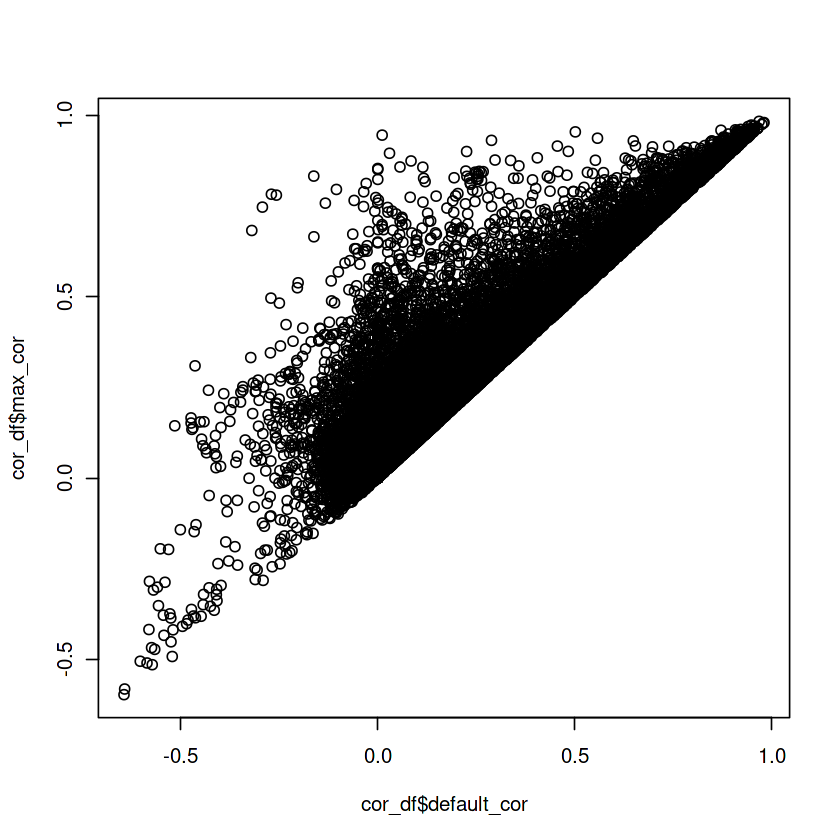

In [16]:
plot(cor_df$default_cor, cor_df$max_cor)

In [17]:
sum(cor_df$diff_default > 0.2)

[1] 2231

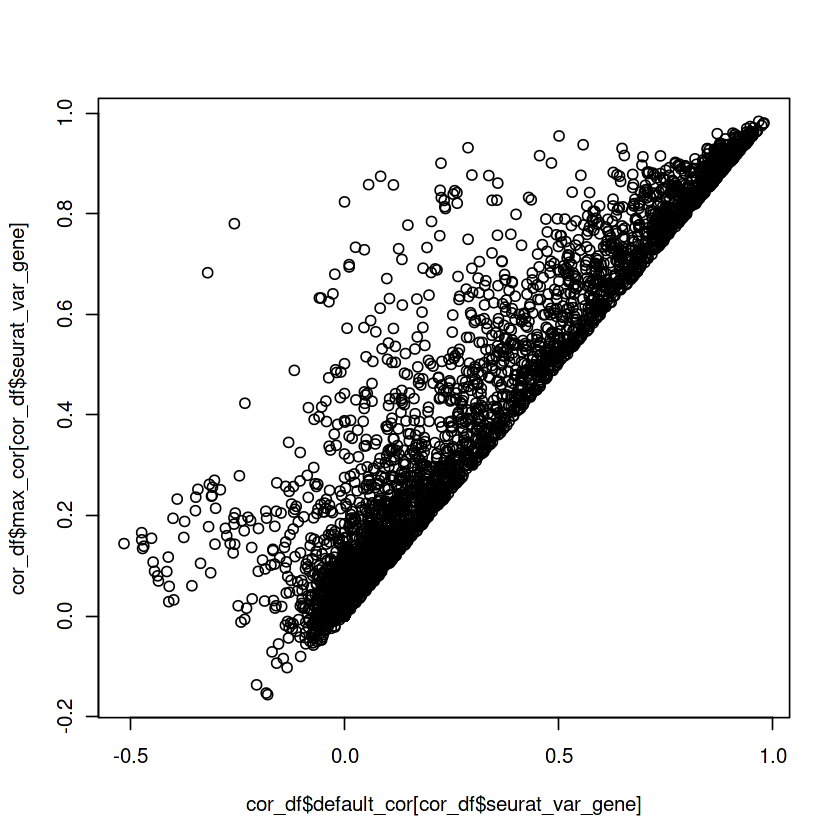

In [18]:
plot(cor_df$default_cor[cor_df$seurat_var_gene], cor_df$max_cor[cor_df$seurat_var_gene])

In [19]:
sum(cor_df$diff_default[cor_df$seurat_var_gene] > 0.2)

[1] 431

Genes that are best correlated to a particular model:

In [20]:
cor_df %>%
  arrange(desc(max_cor)) %>%
  head(10)

,gene,default_cor,max_cor,min_cor,mean_cor,median_cor,diff_cor,diff_default,max_model,min_model,seurat_var_gene
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>
1,WDFY4,0.9677652,0.9834847,0.82075336,0.9418039,0.9689925,0.16273137,0.0157195237,GeneModel-TSS-NoBoundary-Exponential-2,GeneBody_0_0,TRUE
2,LEF1,0.9801195,0.9801195,0.64173822,0.9522541,0.9733219,0.33838126,0.0000000000,GeneModel-GB-Exponential-Extend-15,Promoter_1K,TRUE
3,LYN,0.9784661,0.9788781,0.83576680,0.9585794,0.9755893,0.14311131,0.0004119676,GeneModel-GB-Exponential-Extend-12,Promoter_2K,TRUE
4,ARHGAP24,0.9746609,0.9750289,0.92755333,0.9618976,0.9637603,0.04747561,0.0003680104,GeneModel-GB-Exponential-Extend-1,Promoter_100K,TRUE
5,LEF1,0.9480311,0.9731400,0.76543925,0.9279379,0.9404282,0.20770072,0.0251088756,GeneModel-TSS-NoBoundary-Exponential-4,Promoter_2K,TRUE
6,BLK,0.9551647,0.9706990,0.72875693,0.9381526,0.9511926,0.24194207,0.0155343230,GeneModel-TSS-Exponential-2,Promoter_100K,TRUE
7,HLA-DQA1,0.9397761,0.9691502,0.85903572,0.9405148,0.9442825,0.11011447,0.0293741114,GeneBody_5000_0,Promoter_100K,TRUE
8,MS4A1,0.9648347,0.9649947,0.84082852,0.9471812,0.9614828,0.12416619,0.0001600119,GeneModel-GB-Exponential-Extend-17,GeneModel-TSS-NoBoundary-Exponential-4,TRUE
9,SYK,0.9628870,0.9632573,0.87257248,0.9500966,0.9599529,0.09068484,0.0003702954,GeneModel-GB-Exponential-2,Promoter_1K,TRUE


Genes that can be correlated, but are pretty much model-agnostic:

In [21]:
cor_df %>%
  filter(max_cor > 0.3) %>%
  filter(diff_cor < 0.1) %>%
  arrange(desc(max_cor)) %>%
  head(10)

,gene,default_cor,max_cor,min_cor,mean_cor,median_cor,diff_cor,diff_default,max_model,min_model,seurat_var_gene
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>
1,ARHGAP24,0.9746609,0.9750289,0.9275533,0.9618976,0.9637603,0.04747561,0.0003680104,GeneModel-GB-Exponential-Extend-1,Promoter_100K,TRUE
2,SYK,0.9628870,0.9632573,0.8725725,0.9500966,0.9599529,0.09068484,0.0003702954,GeneModel-GB-Exponential-2,Promoter_1K,TRUE
3,HLA-DQB1-AS1,0.9510532,0.9621849,0.9031567,0.9387877,0.9370935,0.05902818,0.0111317588,GeneModel-GB-NoBoundary-Exponential-1,Promoter_100K,FALSE
4,HLA-DQB1-AS1,0.9342251,0.9613962,0.9008994,0.9370311,0.9400737,0.06049674,0.0271710735,GeneBody_10000_10000,GeneModel-TSS-Constant-3,FALSE
5,HLA-DRB1,0.9508027,0.9573350,0.8945453,0.9442680,0.9510394,0.06278968,0.0065323352,GeneModel-GB-NoBoundary-Exponential-4,GeneBody_0_0,TRUE
6,HLA-DMB,0.9492082,0.9557119,0.8739130,0.9402450,0.9497187,0.08179887,0.0065036943,GeneModel-GB-NoBoundary-Exponential-4,GeneBody_0_0,TRUE
7,HLA-DRB1,0.9479846,0.9556834,0.9011961,0.9396768,0.9442700,0.05448738,0.0076988538,GeneModel-GB-NoBoundary-Exponential-1,GeneModel-TSS-Constant-4,TRUE
8,HLA-DQB1-AS1,0.9476217,0.9549434,0.8734682,0.9389346,0.9478581,0.08147522,0.0073217562,GeneModel-GB-NoBoundary-Exponential-1,GeneBody_0_0,FALSE
9,CCL5,0.9520868,0.9542505,0.8943269,0.9449250,0.9499310,0.05992365,0.0021637463,GeneModel-TSS-Exponential-2,Promoter_1K,TRUE


In [22]:
max_model_tbl <- table(cor_df$max_model)
max_model_tbl <- max_model_tbl[order(max_model_tbl, decreasing = TRUE)]
max_model_tbl


                          GeneBody_0_0  GeneModel-GB-NoBoundary-Exponential-4 
                                  5022                                   2159 
                         Promoter_100K               GeneModel-TSS-Constant-4 
                                  1766                                   1634 
                           Promoter_1K GeneModel-TSS-NoBoundary-Exponential-4 
                                  1320                                   1200 
            GeneModel-GB-Exponential-4               GeneModel-TSS-Constant-3 
                                   986                                    855 
                  GeneBody_10000_10000               GeneModel-TSS-Constant-1 
                                   720                                    643 
                           Promoter_2K                           Promoter_25K 
                                   591                                    556 
              GeneModel-TSS-Constant-2  GeneModel-G

In [23]:
min_model_tbl <- table(cor_df$min_model)
min_model_tbl <- min_model_tbl[order(min_model_tbl, decreasing = TRUE)]
min_model_tbl


                          GeneBody_0_0                            Promoter_1K 
                                  5032                                   3257 
                         Promoter_100K  GeneModel-GB-NoBoundary-Exponential-4 
                                  2391                                   1856 
              GeneModel-TSS-Constant-1               GeneModel-TSS-Constant-4 
                                  1323                                   1321 
                           Promoter_2K               GeneModel-TSS-Constant-3 
                                  1243                                    880 
GeneModel-TSS-NoBoundary-Exponential-4                            Promoter_5K 
                                   860                                    804 
              GeneModel-TSS-Constant-2                           Promoter_25K 
                                   794                                    713 
                  GeneBody_10000_10000             

### For each model, what are the mean/median/quantiles

In [24]:
model_df <- data.frame(
    model_name = colnames(res_mat),
    model_mean = colMeans(res_mat),
    model_min = colMins(res_mat),
    model_q25 = apply(res_mat, 2, quantile, prob = 0.25),
    model_median = colMedians(res_mat),
    model_q75 = apply(res_mat, 2, quantile, prob = 0.75),
    model_max = colMaxs(res_mat)
)

In [25]:
model_df

,model_name,model_mean,model_min,model_q25,model_median,model_q75,model_max
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GeneBody_0_0,GeneBody_0_0,0.11217219,-0.6126308,-1.276460e-03,0.033773765,0.1618487,0.9627524
GeneBody_1000_0,GeneBody_1000_0,0.11312389,-0.6193981,-4.892689e-04,0.035659154,0.1636407,0.9674193
GeneBody_1000_1000,GeneBody_1000_1000,0.11347475,-0.6192151,-5.613582e-04,0.036427606,0.1646281,0.9671598
GeneBody_10000_0,GeneBody_10000_0,0.11427452,-0.6482947,0.000000e+00,0.037090922,0.1655847,0.9669574
GeneBody_10000_10000,GeneBody_10000_10000,0.11474482,-0.6486225,0.000000e+00,0.037201706,0.1688332,0.9643107
GeneBody_2000_0,GeneBody_2000_0,0.11360505,-0.6250425,-3.571007e-04,0.036246430,0.1643187,0.9684448
GeneBody_2000_2000,GeneBody_2000_2000,0.11411786,-0.6239034,-1.875617e-05,0.037005800,0.1660851,0.9683228
GeneBody_5000_0,GeneBody_5000_0,0.11405666,-0.6498177,0.000000e+00,0.036838758,0.1660488,0.9691502
GeneBody_5000_5000,GeneBody_5000_5000,0.11481214,-0.6494222,0.000000e+00,0.037652737,0.1672593,0.9690024


## Which model is close to max for the most genes?
Within 0.05 of the max value

In [26]:
max_vals <- rowMaxs(res_mat)
close_cutoff <- 0.05
n_close_max <- apply(
    res_mat, 2,
    function(x) {
        sum(abs(x - max_vals) < close_cutoff)
    }
)
min_vals <- rowMins(res_mat)
n_close_min <- apply(
    res_mat, 2,
    function(x) {
        sum(abs(x - min_vals) < close_cutoff)
    }
)

In [27]:
model_df$n_close_max <- n_close_max
model_df$n_close_min <- n_close_min

In [28]:
model_df %>%
  arrange(desc(n_close_max))

,model_name,model_mean,model_min,model_q25,model_median,model_q75,model_max,n_close_max,n_close_min
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
GeneModel-GB-NoBoundary-Exponential-2,GeneModel-GB-NoBoundary-Exponential-2,0.13054698,-0.6398229,0.000000e+00,0.049610943,0.1929893,0.9779972,14415,9813
GeneModel-GB-NoBoundary-Exponential-3,GeneModel-GB-NoBoundary-Exponential-3,0.12901037,-0.6427383,0.000000e+00,0.048542886,0.1919002,0.9770669,14402,10117
GeneModel-GB-NoBoundary-Exponential-1,GeneModel-GB-NoBoundary-Exponential-1,0.13040937,-0.6379953,0.000000e+00,0.049877101,0.1924666,0.9780187,14287,9767
GeneModel-GB-NoBoundary-Exponential-4,GeneModel-GB-NoBoundary-Exponential-4,0.12277324,-0.6450402,0.000000e+00,0.043936911,0.1822183,0.9766379,13859,11145
GeneModel-GB-Exponential-Extend-11,GeneModel-GB-Exponential-Extend-11,0.12781476,-0.6468094,0.000000e+00,0.047738919,0.1812766,0.9787361,13702,9978
GeneModel-GB-Exponential-Extend-12,GeneModel-GB-Exponential-Extend-12,0.12828875,-0.6489591,0.000000e+00,0.048250453,0.1825762,0.9789024,13693,9941
GeneModel-GB-Exponential-Extend-7,GeneModel-GB-Exponential-Extend-7,0.12756115,-0.6459295,0.000000e+00,0.047778646,0.1813672,0.9782232,13693,10018
GeneModel-GB-Exponential-3,GeneModel-GB-Exponential-3,0.12704077,-0.6456373,0.000000e+00,0.047821015,0.1809766,0.9785736,13685,10056
GeneModel-GB-Exponential-Extend-9,GeneModel-GB-Exponential-Extend-9,0.12788831,-0.6462725,0.000000e+00,0.047713186,0.1817593,0.9799851,13684,9921


In [29]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] matrixStats_0.61.0 dplyr_1.0.7        H5weaver_1.2.0     rhdf5_2.34.0      
[5] Matrix_1.3-4       data.table_1.14.0  SeuratObject_4.0.2 Seurat_4.0.4      
[9] purrr_0.3.4       

loaded via a namespace (and not attached):
  [1] nlme_3.1-152          spatstat.sparse_2.0-0 RcppAnnoy_0.0.19     
  [4] RColorB